In [1]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import tensorflow as tf
import numpy as np
import re
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, dot, Activation, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K
import tensorflow.keras
import matplotlib.pyplot as plt
import nltk
import io
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
from sklearn.model_selection import train_test_split

# # plot japanese lang
# !pip install japanize_matplotlib
# import japanize_matplotlib
# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# load text file

**this dataset is aleady implemented a SentenceSpace**

In [0]:
num_example = 20000

# create each languages list
def create_lang_list(num_example):
    # load txt file
    lines =  io.open("/content/drive/My Drive/Colab Notebooks/raw.txt", encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_example]]

    return zip(*word_pairs)

In [0]:
en, ja = create_lang_list(num_example)

# Text Pre-processing

**Removing accented characters** 

e.g. é → e.

**Expanding Contractions** 

e.g. don't → do not, I'd → I would

**remove special word** 

e.g. remove "123#@"

**Stemming**

 e.g. corder, codes → code

**Lemmatization**

 e.g. better → good

**Tokenize**

 e.g. I am going to restaurant → [[I], [am], [going], [to], [restaurant]]

# Removing accented characters

English might have accent like é but Japanese doesn't have any accent I just create different function to ascii for Japanese and English

In [0]:
# Removing accented characters
def english_unicode_to_ascii(text):
     return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

def japanese_unicode_to_ascii(text):
    return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text))

In [5]:
# e.g.
japanese_unicode_to_ascii("こんにちは。今日は"), english_unicode_to_ascii("Hello world é ")

('こんにちは。今日は', 'Hello world e ')

# Expanding Contractions
Japanese doesn't have a Contraction words so I just create a one function to expand Contractions for Engish

In [0]:
def expand_constraction(text):

    #  dic for expand constraction words
    constraction_dict= {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    #  define match pattern
    #  IGNORECASE → no matter if word is lowercase or uppercase
    #  DOTAIL → . is going to match \n
    contraction_pattern = re.compile('({})'.format('|'.join(constraction_dict.keys())),
                                                  flags=re.IGNORECASE | re.DOTALL)
    #  expand words
    def expand_match(constraction):
        # get constraction word
        match = constraction.group(0)
        first_char = match[0]
        #  get expand word from constraction dict
        expand_constraction = constraction_dict.get(match)\
                                                    if constraction_dict.get(match) \
                                                    else constraction_dict.get(match.lower())
        
        # create expand constraction
        expand_constraction = first_char + expand_constraction[1:]
        return expand_constraction
    
    expanded_text = contraction_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [7]:
# e.g.
expand_constraction("you're good I'd like to go he's she's")

'you are good I would like to go he is she is'

# remove special characters and create space between word and punctuation

replacing everything with space except(a-z, A-Z, "?", "!", "-", "ー", "Kanji", "Katakana", "Hiragana") 
create space between word and punctuation (? ! )

In [0]:
def replace_special_character_to_space(text):
    pattern = r"[^a-zA-Z\u3041-\u309F\u30A1-\u30FF\uFF66-\uFF9F\u4E00-\u9FD0\u309B\u3099\uFF9E\u309C\u309A\uFF9F?!\s]+"
    text = re.sub(pattern, '', text).rstrip().strip()
    text = text.replace("・" , "")

    text = re.sub(r"([?!.,。、])", r" \1 ", text)
    text = text.lower()

    return text

In [9]:
# e.g.
replace_special_character_to_space("hello, . #@…123world.-------/"), replace_special_character_to_space("こん・にちは。・ いい天気。")

('hello  world', 'こんにちは いい天気')

# Stemming and Lemmatization
I will do stemming only english which can create a base form of a word from a given word. Japanese language doesn't need a stemming

In [0]:
def stemmer_word(text):
    ps = nltk.stem.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [11]:
# e.g.
stemmer_word("hello world she has cat but he had dogs he is went to traveling")

'hello world she ha cat but he had dog he is went to travel'

# Normalize each word

In [0]:
def normalize_english(english_text, japanese_text):
    
    input_value = ()
    target_value = ()
    
    for en_text, ja_text in zip(english_text, japanese_text):
        
        # normalize English
        en_text = english_unicode_to_ascii(en_text)
        en_text = expand_constraction(en_text)
        en_text = replace_special_character_to_space(en_text)

        # input value doesn't need  a START and END sentence  
        input_value += (en_text, )

        # normalize Japanese
        ja_text = japanese_unicode_to_ascii(ja_text)
        ja_text = expand_constraction(ja_text)
        ja_text = replace_special_character_to_space(ja_text)

        # add StTART and END sentence
        ja_text = "START_ " + ja_text + " _END"
        
        target_value += (ja_text, )

    return input_value, target_value

# get clean text data

In [0]:
# get normalize text data
input_value, target_value = normalize_english(en, ja)

# convert to Series
x = pd.Series(input_value) 
y = pd.Series(target_value)

In [135]:
pd.DataFrame({"input": x, "target": y}).head()

,input,target
0,you are back are not you harold ?,START_ あなたは戻ったのね ハロルド ? _END
1,my opponent is shark,START_ 俺の相手は シャークだ _END
2,this is one thing in exchange for another,START_ 引き換えだ ある事とある物の _END
3,yeah i am fine,START_ もういいよ ごちそうさま ううん _END
4,do not come to the office anymore do not call ...,START_ もう会社には来ないでくれ 電話もするな _END


In [136]:
# get unique vocab

# input value 
all_eng = set()
for input_lang in x:
    for word in input_lang.split():
        if word not in all_eng:
            all_eng.add(word)

# target value
all_ja = set()
for target_lang in y:
    for word in target_lang.split():
        if word not in all_ja:
            all_ja.add(word)

print("unique vocab %d" % len(all_eng))
print("unique vocab %d" %len(all_ja))

unique vocab 13247
unique vocab 28951


english length: 43
japanese length: 18


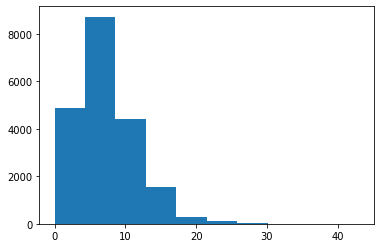

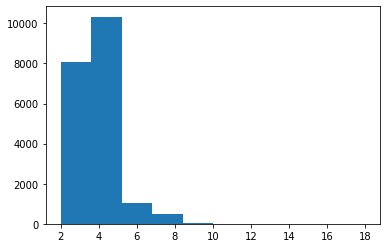

In [137]:
# max length of input sentense and target sentense
english_len = [len(i.split()) for i in x]

japanese_len = [len(i.split()) for i in y]

plt.figure()
plt.hist(english_len)

plt.figure()
plt.hist(japanese_len)

# print max length
print("english length:", max(english_len))
print("japanese length:", max(japanese_len))
max_len_input =  max(english_len)
max_len_target =  max(japanese_len)

In [138]:
input_word = list(all_eng)
target_word = list(all_ja)

num_encoder_tokens = len(all_eng)
num_decoder_tokens = len(all_ja)
num_encoder_tokens, num_decoder_tokens

(13247, 28951)

In [0]:
num_encoder_tokens += 1
num_decoder_tokens += 1

In [0]:
def create_token(token_index_dic, words):
  count = 2
  for word in words:
    if word == "START_":
      continue
    token_index_dic[word] = count
    count += 1

  return token_index_dic

input_token_index = {}
target_token_index = {"START_": 1}

input_token_index = create_token(input_token_index, input_word)
target_token_index = create_token(target_token_index, target_word)

In [0]:
reverse_input_char = dict((i, word) for word, i in input_token_index.items())
reverse_target_char = dict((i, word) for word, i in target_token_index.items())

# Create train dataset

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=33)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test , test_size=0.5, random_state=42)

In [143]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((13400,), (3300,), (3300,), (13400,), (3300,), (3300,))

# Create generater¶

In [0]:
# create a batch of data
def generate_batch(X, Y, batch_size):
    while True:
        assert len(X) == len(Y)
        for i in range(0, len(X), batch_size):
            # initialize input and target data
            encoder_input_data = np.zeros((batch_size, max_len_input), dtype="float32")
            decoder_input_data = np.zeros((batch_size, max_len_target), dtype="float32")
            decoder_target_data = np.zeros((batch_size, max_len_target, num_decoder_tokens), dtype="float32")
            for j, (input_text, target_text) in enumerate(zip(X[i: i+batch_size], Y[i: i+batch_size])):
                    # create enocder input dataset
                    for t, word in enumerate(input_text.split()):
                        encoder_input_data[j, t] = input_token_index[word]
                    # create decoder input dataset
                    for t, word in enumerate(target_text.split()):
                        if t < len(target_text.split())-1:
                            decoder_input_data[j, t] = target_token_index[word]
                        # decoder  output is one-hot encoding
                        # doesn't include START sentense
                        # one timestep ahead of input 
                        if t > 0:
                            decoder_target_data[j, t-1, target_token_index[word]] = 1.
                    yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Define for params

In [0]:
# initial hyper parameter
BATCH_SIZE = 16
dropout_rate = 0.5
units = 64
lr = 0.00001
l2 = 0.006

# Build a model

In [0]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [160]:
# define time step and dimention size for embedding and LSTM
in_timesteps = max_len_input
out_timesteps = max_len_target

# build encoder model
encoder_input = Input(shape=(in_timesteps, ))

# use pre-trained model Word2Vec
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=units, mask_zero=True)(encoder_input) 

# Dropout
encoder = Dropout(rate=dropout_rate)(encoder_embedding)

# get enternal state to predict target value
# encode output is going to use for attention
encoder_output, state_h, state_c = LSTM(units, return_sequences=True, return_state=True, unroll=True, kernel_regularizer=regularizers.l2(l2))(encoder)

encoder_states = [state_h, state_c]

# build decoder model
decoder_input = Input(shape=(out_timesteps, ))

# use pre-trained model Word2Vec
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=units, mask_zero=True)
decoder_emb = decoder_embedding(decoder_input)

# Dropout
decoder = Dropout(rate=dropout_rate)(decoder_emb)

decoder_lstm = LSTM(units, return_sequences=True, unroll=True, return_state=True, kernel_regularizer=regularizers.l2(l2))
# we don't use return state in the train model
decoder, _, _ = decoder_lstm(decoder,  initial_state=encoder_states)

# Dropout
decoder = Dropout(rate=dropout_rate)(decoder)

# get attention weight
attention = dot([decoder, encoder_output], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)

context = dot([attention, encoder_output], axes=[2,1])

decoder_combined_context = tf.keras.layers.concatenate([context, decoder])

# Dropout
decoder_combined_context = Dropout(rate=dropout_rate)(decoder_combined_context)

output = TimeDistributed(Dense(units, activation="tanh"))(decoder_combined_context)

# Dropout
output = Dropout(rate=dropout_rate)(output)

output = TimeDistributed(Dense(num_decoder_tokens, activation="softmax"))(output)

model = Model(inputs=[encoder_input, decoder_input], outputs=[output])

model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 43)]         0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 43, 64)       847872      input_27[0][0]                   
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 18, 64)       1852928     input_28[0][0]                   
___________________________________________________________________________________________

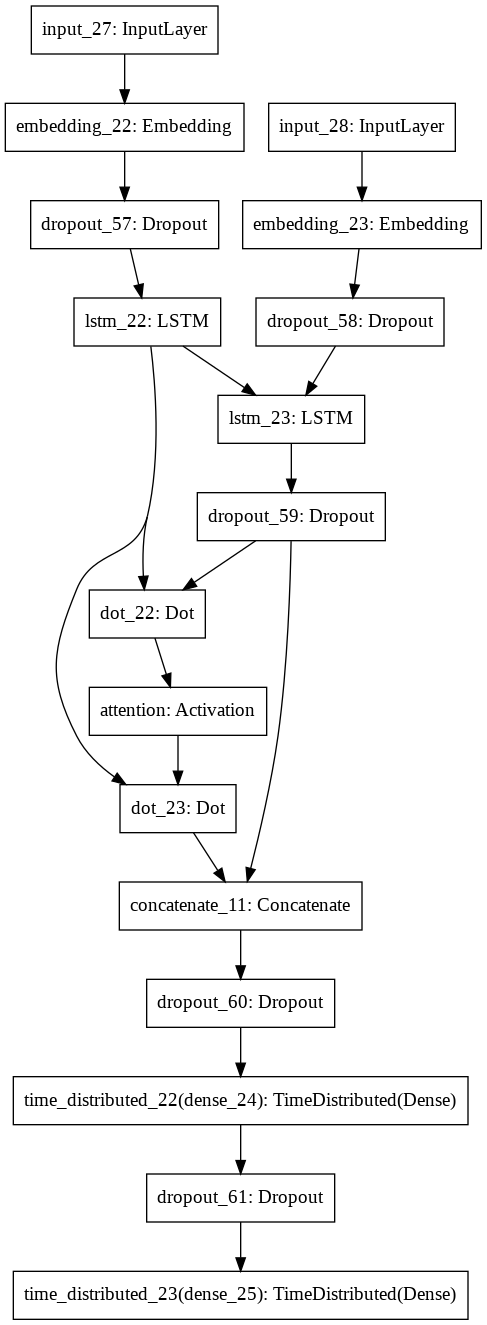

In [161]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='multiple_inputs.png')

In [162]:
# create dataset as generater
gen_train = generate_batch(X_train, Y_train, batch_size=BATCH_SIZE)
gen_test = generate_batch(X_test, Y_test, BATCH_SIZE)
gen_val = generate_batch(X_val, Y_val, BATCH_SIZE)

# caluclate train step
from math import ceil
trian_step = ceil(len(X_train) / BATCH_SIZE)
test_step = ceil(len(X_test) / BATCH_SIZE)
val_step = ceil(len(X_val) / BATCH_SIZE)

trian_step, val_step, test_step

(838, 207, 207)

In [163]:
# checkpoint
filename = 'model.h1.22_Nov_19'

checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min')
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
#                                                  patience=3, min_lr=lr)
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)

callbacks=[checkpoint, es]

# train model
history = model.fit_generator(generator=gen_train, steps_per_epoch=trian_step, epochs=10, verbose=1,
                    callbacks=callbacks, validation_data=gen_val, validation_steps=val_step)

Epoch 1/10
838/838 [==============================] - 220s 263ms/step - loss: 1.1062 - acc: 0.3380 - val_loss: 1.0765 - val_acc: 0.3395
Epoch 2/10
838/838 [==============================] - 103s 123ms/step - loss: 1.0456 - acc: 0.3373 - val_loss: 1.0526 - val_acc: 0.3450
Epoch 3/10
838/838 [==============================] - 102s 122ms/step - loss: 1.0386 - acc: 0.3372 - val_loss: 1.0632 - val_acc: 0.3397
Epoch 4/10
838/838 [==============================] - 103s 123ms/step - loss: 1.0034 - acc: 0.3569 - val_loss: 1.1104 - val_acc: 0.3359
Epoch 5/10
838/838 [==============================] - 103s 123ms/step - loss: 1.0015 - acc: 0.3662 - val_loss: 0.9982 - val_acc: 0.3558
Epoch 6/10
838/838 [==============================] - 103s 122ms/step - loss: 1.0166 - acc: 0.3561 - val_loss: 1.0428 - val_acc: 0.3619
Epoch 7/10
838/838 [==============================] - 102s 122ms/step - loss: 1.0441 - acc: 0.3549 - val_loss: 1.0257 - val_acc: 0.3589
Epoch 8/10
838/838 [============================

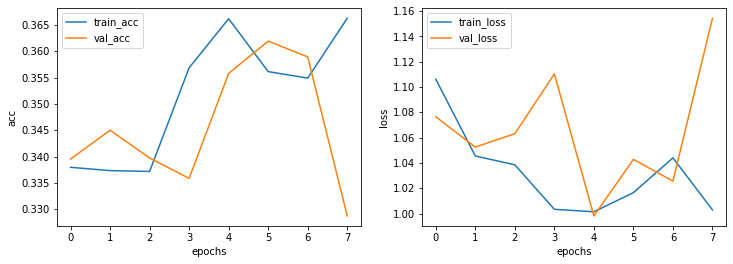

In [164]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["acc"])
ax1.plot(history.history["val_acc"])
ax1.set_xlabel("epochs")
ax1.set_ylabel("acc")
ax1.legend(["train_acc", "val_acc"])

ax2.plot(history.history["loss"])
ax2.plot(history.history["val_loss"])
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.legend(["train_loss", "val_loss"])
plt.show()

In [0]:
# load model
model = load_model('model.h1.22_Nov_19')

# Test

In [166]:
score = model.evaluate_generator(gen_test, steps=test_step)
print("loss {}".format(score[0]))
print("acc {}".format(score[1]))

loss 1.0685589684956316
acc 0.3546530306339264


# define testing model

In [69]:
# encoder model
encoder_input = model.input[0] # enocoder input
encoder_output, state_h, state_c = model.layers[6].output # encoder lstm
encoder_staet = [state_h, state_c]
encoder_model = Model(encoder_input, encoder_staet)
encoder_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 40)]              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 40, 64)            554752    
_________________________________________________________________
dropout_37 (Dropout)         (None, 40, 64)            0         
_________________________________________________________________
lstm_14 (LSTM)               [(None, 40, 64), (None, 6 33024     
Total params: 587,776
Trainable params: 587,776
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.layers

In [71]:
# decoder model
decoder_input = model.input[1] # decoder input
decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
decoder_emb = model.layers[3]
deocder_emb = decoder_emb(decoder_input)
decoder_lstm = model.layers[7] # decoder lstm
decoder_output, dec_state_h, dec_state_c = decoder_lstm(deocder_emb, initial_state=decoder_state_input)
decoder_state = [dec_state_h, dec_state_c]


decoder_dense = model.layers[16]
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_input, [decoder_output] + decoder_state)
decoder_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 12, 64)       953280      input_18[0][0]                   
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 64)]         0                                            
___________________________________________________________________________________________

In [0]:
def decoder_seq(input_seq):
    # encoder the input seq as vector
    state_en= encoder_model.predict(input_seq)
    # generate empty target sequence
    target_seq = np.zeros((1, out_timesteps))
    # populate the first character of target seq
    target_seq[0, 0] = 1

    # loop for batch of sequences
    stop_condition = False
    decoder_sentence = ' '

    while not stop_condition:
        output_token, h, c = decoder_model.predict([target_seq] + state_en)

        sampled_token_index = np.argmax(output_token[0, -1, :])
        sampled_char = reverse_target_char[sampled_token_index]
        decoder_sentence += ' ' + sampled_char

        # stop condition
        if sampled_char == "_END" or len(decoder_sentence) > max_len_input:
          stop_condition = True
        

        # update the target sequence
        target_seq = np.zeros((1, out_timesteps))
        target_seq[0, 0] = 1.

        # update states
        en_state = [h, c]
    
    return decoder_sentence

In [0]:
test_ge = generate_batch(X_test, Y_test, 1)
k = -1

In [125]:
k+=1
(input_seq, actual_output), _ = next(test_ge)
decoder_sentence = decoder_seq(input_seq)
print("input english %s" % X_test[k:k+1].values[0])
print("actual %s" % Y_test[k:k+1].values[0][6:-4])
print("predict %s" % decoder_sentence[:-4] )

from nltk.translate.bleu_score import sentence_bleu

# calculate BLEU score
print('BLEU corpus: %f' % sentence_bleu([Y_test[k:k+1].values[0][6:-4].strip().split(" ")], decoder_sentence[:-4].strip().split(" ")))

input english well it will not take long
actual  すぐ終わるわ m 
predict   
BLEU corpus: 0.000000


# plot attention

In [0]:
# create attention
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 18, 69149), (None, 18, 44)]


In [0]:
!pip install japanize-matplotlib
import japanize_matplotlib
import matplotlib.ticker as ticker

decoder_input = np.zeros(shape=(len(input_seq), out_timesteps))
decoder_input[:,0] = start_word

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += decoding[i]
    return text

def create_output():
  for i in range(1, out_timesteps):
    output, attention = attention_model.predict([input_seq, decoder_input])
    decoder_input[:, i] = output.argmax(axis=2)[:, i]
    attention_density = attention[0]
    decoder_out = decode(reverse_target_char, decoder_input[0][1:])
  return attention_density, decoder_out

def visualize(text):
  attention_density, decoder_out = create_output()

  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention_density[:len(decoder_out), :len(text)+1], cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + Y_test[k:k+1].values[0][6:-4].split(" "), fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + decoder_out.split(" "), fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

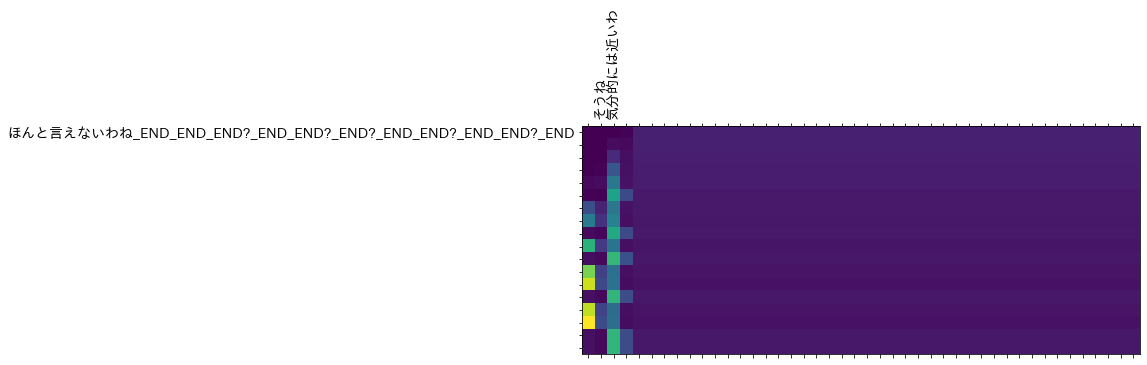

In [0]:
visualize(decoder_sentence)